# Define model

In [1]:
import pyprob
import numpy as np
import torch

from pyprob.dis import ModelDIS
from showerSim import invMass_ginkgo
from pyprob.nn.dataset import OnlineDataset
from pyprob.util import InferenceEngine
from pyprob import Model
import math
from pyprob.distributions import Normal
from pyprob.distributions.delta import Delta


import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as mpl_cm
plt.ion()

import sklearn as skl
from sklearn.linear_model import LinearRegression

[pyKeOps]: Warning, no cuda detected. Switching to cpu only.


In [2]:
# obs_leaves = torch.tensor([[44.57652381, 26.16169856, 25.3945314 , 25.64598258],
#        [18.2146321 , 10.70465096, 10.43553391, 10.40449709],
#        [ 6.47106713,  4.0435395,  3.65545951,  3.48697568],
#        [ 8.43764314,  5.51040615,  4.60990593,  4.42270416],
#        [26.61664145, 16.55894826, 14.3357362 , 15.12215264],
#        [ 8.62925002,  3.37121204,  5.19699   ,  6.00480461],
#        [ 1.64291837,  0.74506775,  1.01003622,  1.05626017],
#        [ 0.75525072,  0.3051808 ,  0.45721085,  0.51760643],
#        [39.5749915 , 18.39638928, 24.24717939, 25.29349408],
#        [ 4.18355659,  2.11145474,  2.82071304,  2.25221316],
#        [ 0.82932922,  0.29842766,  0.5799056 ,  0.509021  ],
#        [ 3.00825023,  1.36339397,  1.99203677,  1.79428211],
#        [ 7.20024308,  4.03280868,  3.82379277,  4.57441754],
#        [ 2.09953618,  1.28473579,  1.03554351,  1.29769683],
#        [12.21401828,  6.76059035,  6.94920042,  7.42823701],
#        [ 6.91438054,  3.68417135,  3.83782514,  4.41656731],
#        [ 1.97218904,  1.01632927,  1.08008339,  1.27454585],
#        [ 8.58164301,  5.06157833,  4.79691164,  4.99553141],
#        [ 5.97809522,  3.26557958,  3.4253764 ,  3.64894791],
#        [ 5.22842301,  2.94437891,  3.10292633,  3.00551074],
#        [15.40023764,  9.10884407,  8.93836964,  8.61970667],
#        [ 1.96101346,  1.24996337,  1.06923988,  1.06743143],
#        [19.81054106, 11.90268453, 11.60989346, 10.76953856],
#        [18.79470876, 11.429855  , 10.8377334 , 10.25112761],
#        [25.74331932, 15.63430056, 14.83860792, 14.07189108],
#        [ 9.98357576,  6.10090721,  5.68664128,  5.48748692],
#        [12.34604239,  7.78770185,  6.76075998,  6.78498685],
#        [21.24998531, 12.95180254, 11.9511704 , 11.87319933],
#        [ 7.80693733,  4.83117128,  4.27443559,  4.39602348],
#        [16.28983576,  9.66683929,  9.24891886,  9.28970032],
#        [ 2.50706736,  1.53153206,  1.36060018,  1.43002765],
#        [ 3.73938645,  2.06006639,  2.31013974,  2.09378969],
#        [20.2174725 , 11.88622367, 12.05106468, 11.05325362],
#        [ 9.48660008,  5.53665456,  5.54171966,  5.34966654],
#        [ 2.65812987,  1.64102742,  1.67392209,  1.25083707]], dtype=torch.float64)


# QCD_mass = 30.
# #rate=torch.tensor([QCD_rate,QCD_rate]) #Entries: [root node, every other node] decaying rates. Choose same values for a QCD jet
# jetdir = np.array([1,1,1])
# jetP = 400.
# jetvec = jetP * jetdir / np.linalg.norm(jetdir) ## Jetvec is 3-momentum. JetP is relativistic p.


# # Actual parameters
# pt_min = torch.tensor(0.3**2)
# M2start = torch.tensor(QCD_mass**2)
# jetM = np.sqrt(M2start.numpy()) ## Mass of initial jet
# jet4vec = np.concatenate(([np.sqrt(jetP**2 + jetM**2)], jetvec))
# minLeaves = 1
# maxLeaves = 10000 # unachievable, to prevent rejections
# maxNTry = 100

# def dummy_bernoulli(self, jet):
#     return True

# class SimulatorModelDIS(invMass_ginkgo.SimulatorModel, ModelDIS):
#     def forward(self, inputs=None):
#         assert inputs is None # Modify code if this ever not met?
#         # Sample parameter of interest from Unif(0,10) prior
#         root_rate = pyprob.sample(pyprob.distributions.Uniform(0.01, 10.),
#                             name="decay_rate_parameter")
#         decay_rate = pyprob.sample(pyprob.distributions.Uniform(0.01, 10.),
#                                    name="decay_rate_parameter")
#         # Simulator code needs two decay rates for (1) root note (2) all others
#         # For now both are set to the same value
#         inputs = [root_rate, decay_rate]
#         return super().forward(inputs)

# # Make instance of the simulator
# simulator = SimulatorModelDIS(jet_p=jet4vec,  # parent particle 4-vector
#                               pt_cut=float(pt_min),  # minimum pT for resulting jet
#                               Delta_0= M2start,  # parent particle mass squared -> needs tensor
#                               M_hard=jetM,  # parent particle mass
#                               minLeaves=1,  # minimum number of jet constituents
#                               maxLeaves=10000,  # maximum number of jet constituents (a large value to stop expensive simulator runs)
#                               bool_func=dummy_bernoulli,
#                               suppress_output=True,
#                               obs_leaves=obs_leaves)


In [3]:
def euclidean(a,b):
    a = np.asarray(a)
    b = np.asarray(b)
    return np.linalg.norm(a-b)

class GaussianUnknownMean(Model):
    def __init__(self, **kwargs):
        super().__init__(name='Gaussian with unknown mean', **kwargs) # give the model a name
        self.prior_mean = 1
        self.prior_std = math.sqrt(5)
        self.likelihood_std = math.sqrt(2)

    def forward(self): # Needed to specifcy how the generative model is run forward
        # sample the (latent) mean variable to be inferred:
        mu = pyprob.sample(Normal(self.prior_mean, self.prior_std)) # NOTE: sample -> denotes latent variables

        # define the likelihood
        #likelihood = Normal(mu, self.likelihood_std)

        # Lets add two observed variables
        # -> the 'name' argument is used later to assignment values:
        #pyprob.observe(likelihood, name='obs0') # NOTE: observe -> denotes observable variables

        # return the latent quantity of interest
        return mu
    
class GaussianDIS(GaussianUnknownMean, ModelDIS):
    def __init__(self,  dist_fun = None, **kwargs):
        super().__init__(dist_fun = dist_fun)
        self.obs = 8
        #self.bool_func = bool_func
    def dummy_bernoulli(self, x):
        return True
    def forward(self):
        x = super().forward()
        likelihood = Normal(x, self.likelihood_std) 
        pyprob.observe(likelihood, name = 'sample_obs')
        delta_val = self.dummy_bernoulli(x)
        bool_func_dist = pyprob.distributions.Bernoulli(delta_val)
        pyprob.observe(bool_func_dist, name = "dummy")
        return x


model = GaussianUnknownMean()
simulator = GaussianDIS(dist_fun = euclidean)

# Dataset test

In [ ]:
dataset = OnlineDataset(simulator, inference_engine=InferenceEngine.DISTILLING_IMPORTANCE_SAMPLING,importance_sample_size=5000)

In [ ]:
trace = dataset[0]

In [ ]:
trace.log_prob

# Inference test

In [4]:
simulator.train()

Creating new inference network...
Observable dummy: reshape not specified, using shape torch.Size([]).
Observable dummy: using embedding dim torch.Size([1]).
Observable dummy: observe embedding not specified, using the default FEEDFORWARD.
Observable dummy: using embedding depth 1.
Observe embedding dimension: 1
Train. time | Epoch| Trace     | Init. loss| Min. loss | Curr. loss| T.since min | Learn.rate| Traces/sec
New layers, address: 16__forward__mu__Normal__1, distribution: Normal
Total addresses: 1, parameters: 516
0d:00:00:01 | 1    | 400       | +2.22e+00 | +2.21e+00 | +2.28e+00 | 0d:00:00:00 | +1.00e-03 | 381.6                               
Stop condition reached. num_traces: 500
0d:00:00:01 | 1    | 500       | +2.22e+00 | +2.20e+00 | +2.20e+00 | 0d:00:00:00 | +1.00e-03 | 451.2 
Training iterations 1  epsilon inf  ESS 0.0
Continuing to train existing inference network...
Total number of parameters: 516
Train. time | Epoch| Trace     | Init. loss| Min. loss | Curr. loss| T.sin

/home/sragy/DISPyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 32__forward__?__Normal__1
  warnings.warn('Using prior. No proposal for address: {}'.format(address))


0d:00:00:07 | 0d:00:00:00 | #################### | 1000/1000 | 817.26 | 127.31       
0d:00:00:09 | 1    | 600       | +2.22e+00 | +2.20e+00 | +2.23e+00 | 0d:00:00:07 | +1.00e-03 | 12.6 
Stop condition reached. num_traces: 500
0d:00:00:09 | 1    | 1,000     | +2.22e+00 | +2.20e+00 | +2.39e+00 | 0d:00:00:08 | +1.00e-03 | 2,473.5 
Training iterations 2  epsilon 3.60  ESS 817.3
Continuing to train existing inference network...
Total number of parameters: 516
Train. time | Epoch| Trace     | Init. loss| Min. loss | Curr. loss| T.since min | Learn.rate| Traces/sec
Time spent  | Time remain.| Progress             | Trace     | ESS    | Traces/sec
0d:00:00:08 | 0d:00:00:00 | #################### | 1000/1000 | 825.27 | 114.88       
0d:00:00:18 | 1    | 1,100     | +2.22e+00 |  | +2.40e+00 |  | +1.00e-03 | 11.4 
Stop condition reached. num_traces: 500
0d:00:00:18 | 1    | 1,500     | +2.22e+00 | +2.20e+00 | +2.38e+00 | 0d:00:00:08 | +1.00e-03 | 3,006.7 
Training iterations 3  epsilon 3.59  ESS

In [5]:
simulator.train(iterations = 40)

Continuing to train existing inference network...
Total number of parameters: 516
Train. time | Epoch| Trace     | Init. loss| Min. loss | Curr. loss| T.since min | Learn.rate| Traces/sec
Time spent  | Time remain.| Progress             | Trace     | ESS    | Traces/sec


/home/sragy/DISPyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 32__forward__?__Normal__1
  warnings.warn('Using prior. No proposal for address: {}'.format(address))


0d:00:00:07 | 0d:00:00:00 | #################### | 1000/1000 | 798.48 | 131.56       
0d:00:01:24 | 1    | 5,100     | +2.22e+00 | +2.20e+00 | +2.35e+00 | 0d:00:00:07 | +1.00e-03 | 13.1 
Stop condition reached. num_traces: 500
0d:00:01:24 | 1    | 5,500     | +2.22e+00 | +2.20e+00 | +2.35e+00 | 0d:00:00:07 | +1.00e-03 | 2,745.9 
Training iterations 1  epsilon 3.07  ESS 798.5
Continuing to train existing inference network...
Total number of parameters: 516
Train. time | Epoch| Trace     | Init. loss| Min. loss | Curr. loss| T.since min | Learn.rate| Traces/sec
Time spent  | Time remain.| Progress             | Trace     | ESS    | Traces/sec
0d:00:00:06 | 0d:00:00:00 | #################### | 1000/1000 | 782.74 | 146.05       
0d:00:01:31 | 1    | 5,600     | +2.22e+00 | +2.20e+00 | +2.31e+00 | 0d:00:00:06 | +1.00e-03 | 14.4 
Stop condition reached. num_traces: 500
0d:00:01:31 | 1    | 6,000     | +2.22e+00 | +2.20e+00 | +2.23e+00 | 0d:00:00:07 | +1.00e-03 | 2,689.8 
Training iterations 

In [7]:
results = simulator.posterior_results(num_traces=1000, inference_engine=InferenceEngine.DISTILLING_IMPORTANCE_SAMPLING, observe = {'dummy':1})

Time spent  | Time remain.| Progress             | Trace     | ESS    | Traces/sec


/home/sragy/DISPyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 32__forward__?__Normal__1
  warnings.warn('Using prior. No proposal for address: {}'.format(address))


0d:00:00:11 | 0d:00:00:00 | #################### | 1000/1000 |   7.53 | 85.16       


(array([  4.,   4.,  38., 110., 218., 295., 214.,  89.,  25.,   3.]),
 array([ 0.7284901,  1.6807522,  2.6330142,  3.5852761,  4.537538 ,
         5.4898   ,  6.442062 ,  7.3943243,  8.346586 ,  9.298848 ,
        10.25111  ], dtype=float32),
 <BarContainer object of 10 artists>)

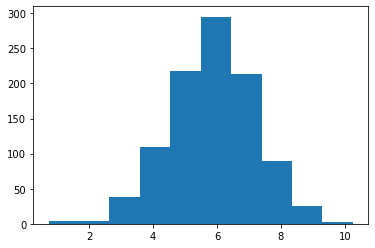

In [10]:
plt.hist(np.array(results))

# Posterior

Correct posterior

In [6]:
def plot_function(min_val, max_val, func, *args, **kwargs):
        x = np.linspace(min_val,max_val,int((max_val-min_val)*50))
        plt.plot(x, np.vectorize(func)(x), *args, **kwargs)

def get_dist_pdf(dist):
    return lambda x: math.exp(dist.log_prob(x))
        
class CorrectDistributions:
    def __init__(self, model):
        self.prior_mean = model.prior_mean
        self.prior_std = model.prior_std
        self.likelihood_std = model.likelihood_std
        self.prior_dist = Normal(self.prior_mean, self.prior_std)
        
    @property
    def observed_list(self):
        return self.__observed_list

    @observed_list.setter
    def observed_list(self, new_observed_list):
        self.__observed_list = new_observed_list
        self.construct_correct_posterior()
    
    def construct_correct_posterior(self):
        n = len(self.observed_list)
        posterior_var = 1/(n/self.likelihood_std**2 + 1/self.prior_std**2)
        posterior_mu = posterior_var * (self.prior_mean/self.prior_std**2 + n*np.mean(self.observed_list)/self.likelihood_std**2)
        self.posterior_dist = Normal(posterior_mu, math.sqrt(posterior_var))

    def prior_pdf(self, model, x):
        p = Normal(model.prior_mean,model.prior_stdd)
        return math.exp(p.log_prob(x))

    def plot_posterior(self, min_val, max_val):
        if not hasattr(self, 'posterior_dist'):
            raise AttributeError('observed values are not set yet, and posterior is not defined.')
        plot_function(min_val, max_val, get_dist_pdf(self.posterior_dist), label='correct posterior', color='orange')


    def plot_prior(self, min_val, max_val):
        plot_function(min_val, max_val, get_dist_pdf(self.prior_dist), label='prior', color='green')

correct_dists = CorrectDistributions(model)

In [7]:
prior = model.prior_results(num_traces=1000)

Time spent  | Time remain.| Progress             | Trace     | ESS    | Traces/sec
0d:00:00:00 | 0d:00:00:00 | #################### | 1000/1000 | 1000.00 | 1,126.46       


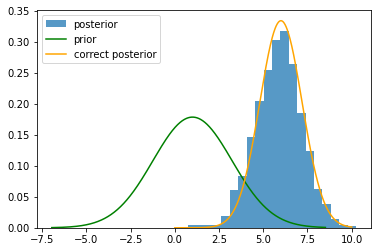

In [18]:
correct_dists.observed_list = [8]
plt.hist(np.array(results), bins=20, alpha=0.75, label='posterior', density=True)
correct_dists.plot_prior(min(prior.values_numpy()),max(prior.values_numpy()))
correct_dists.plot_posterior(0,10)
plt.legend()

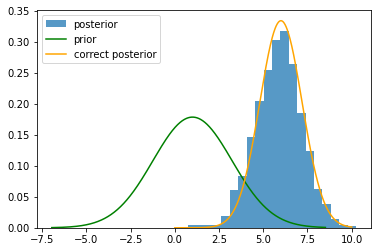

In [20]:
correct_dists.observed_list = [8]
plt.hist(np.array(unweighted_results), bins=20, alpha=0.75, label='posterior', density=True)
correct_dists.plot_prior(min(prior.values_numpy()),max(prior.values_numpy()))
correct_dists.plot_posterior(0,10)
plt.legend()

In [21]:
results = simulator.posterior_results(num_traces=200, inference_engine=InferenceEngine.DISTILLING_IMPORTANCE_SAMPLING, observe = {'dummy':1})

Time spent  | Time remain.| Progress             | Trace   | ESS   | Traces/sec


/home/sragy/DISPyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 32__forward__?__Normal__1
  warnings.warn('Using prior. No proposal for address: {}'.format(address))


0d:00:00:02 | 0d:00:00:00 | #################### | 200/200 |  9.38 | 92.72        


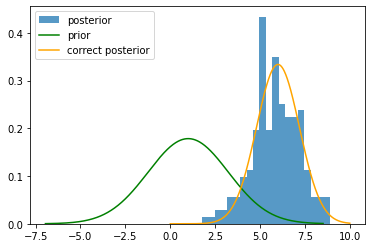

In [22]:
correct_dists.observed_list = [8]
plt.hist(np.array(results), bins=20, alpha=0.75, label='posterior', density=True)
correct_dists.plot_prior(min(prior.values_numpy()),max(prior.values_numpy()))
correct_dists.plot_posterior(0,10)
plt.legend()

In [23]:
posterior = simulator.posterior(num_traces=200, inference_engine=InferenceEngine.DISTILLING_IMPORTANCE_SAMPLING, observe = {'dummy':1})

Time spent  | Time remain.| Progress             | Trace   | ESS   | Traces/sec


/home/sragy/DISPyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 32__forward__?__Normal__1
  warnings.warn('Using prior. No proposal for address: {}'.format(address))


0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 |  9.82 | 101.61       


In [26]:
unweighted = np.array([posterior.values[i].result for i in range(200)])

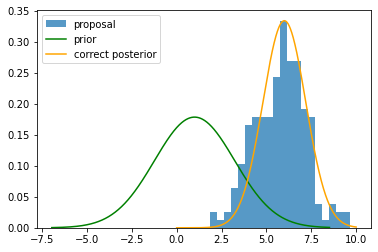

In [28]:
correct_dists.observed_list = [8]
plt.hist(np.array(unweighted), bins=20, alpha=0.75, label='proposal', density=True)
correct_dists.plot_prior(min(prior.values_numpy()),max(prior.values_numpy()))
correct_dists.plot_posterior(0,10)
plt.legend()

# Delta Tests

In [4]:
def euclidean(a,b):
    a = np.asarray(a)
    b = np.asarray(b)
    return np.linalg.norm(a-b)

    
class GaussianDISDelta(GaussianUnknownMean, ModelDIS):
    def __init__(self,  dist_fun = None, **kwargs):
        super().__init__(dist_fun = dist_fun)
        self.obs = 8
        #self.bool_func = bool_func
    def dummy_bernoulli(self, x):
        return True
    def forward(self):
        x = super().forward()
        likelihood = Normal(x, self.likelihood_std) 
        val = pyprob.sample(likelihood)
        delta = Delta(val)
        pyprob.observe(delta, name = 'sample_obs')
        delta_val = self.dummy_bernoulli(x)
        bool_func_dist = pyprob.distributions.Bernoulli(delta_val)
        pyprob.observe(bool_func_dist, name = "dummy")
        return x


simulatordelta = GaussianDISDelta(dist_fun = euclidean)

In [5]:
simulatordelta.train(iterations = 50)

Creating new inference network...
Observable dummy: reshape not specified, using shape torch.Size([]).
Observable dummy: using embedding dim torch.Size([1]).
Observable dummy: observe embedding not specified, using the default FEEDFORWARD.
Observable dummy: using embedding depth 1.
Observe embedding dimension: 1
Train. time | Epoch| Trace     | Init. loss| Min. loss | Curr. loss| T.since min | Learn.rate| Traces/sec
New layers, address: 16__forward__mu__Normal__1, distribution: Normal
New layers, address: 28__forward__val__Normal__1, distribution: Normal
Total addresses: 2, parameters: 1,026
0d:00:00:01 | 1    | 400       | +3.99e+00 | +3.99e+00 | +4.03e+00 | 0d:00:00:01 | +1.00e-03 | 210.8                               
Stop condition reached. num_traces: 500
0d:00:00:01 | 1    | 500       | +3.99e+00 | +3.99e+00 | +4.10e+00 | 0d:00:00:01 | +1.00e-03 | 332.1                               
Training iterations 1  epsilon inf  ESS 0.0
Continuing to train existing inference network...
Tot

/home/sragy/DISPyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 50__forward__?__Delta__1
  warnings.warn('Using prior. No proposal for address: {}'.format(address))


0d:00:00:17 | 0d:00:00:00 | #################### | 1000/1000 | 917.63 | 55.76       
0d:00:00:19 | 1    | 600       | +3.99e+00 | +3.97e+00 | +3.97e+00 | 0d:00:00:00 | +1.00e-03 | 5.5 
Stop condition reached. num_traces: 500
0d:00:00:20 | 1    | 1,000     | +3.99e+00 | +3.85e+00 | +4.10e+00 | 0d:00:00:00 | +1.00e-03 | 2,375.1                           
Training iterations 2  epsilon 3.67  ESS 917.6
Continuing to train existing inference network...
Total number of parameters: 1,026
Train. time | Epoch| Trace     | Init. loss| Min. loss | Curr. loss| T.since min | Learn.rate| Traces/sec
Time spent  | Time remain.| Progress             | Trace     | ESS    | Traces/sec
0d:00:00:16 | 0d:00:00:00 | #################### | 1000/1000 | 935.01 | 61.83       
0d:00:00:36 | 1    | 1,100     | +3.99e+00 |  | +4.36e+00 |  | +1.00e-03 | 6.2 
Stop condition reached. num_traces: 500
0d:00:00:36 | 1    | 1,500     | +3.99e+00 | +3.85e+00 | +4.22e+00 | 0d:00:00:16 | +1.00e-03 | 2,562.1 
Training iterati

Time spent  | Time remain.| Progress             | Trace   | ESS   | Traces/sec


/home/sragy/DISPyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 50__forward__?__Delta__1
  warnings.warn('Using prior. No proposal for address: {}'.format(address))


0d:00:00:03 | 0d:00:00:00 | #################### | 200/200 |  3.54 | 56.43       


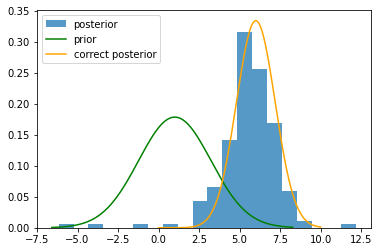

In [9]:
results = simulatordelta.posterior_results(num_traces=200, inference_engine=InferenceEngine.DISTILLING_IMPORTANCE_SAMPLING, observe = {'dummy':1})
correct_dists.observed_list = [8]
plt.hist(np.array(results), bins=20, alpha=0.75, label='posterior', density=True)
correct_dists.plot_prior(min(prior.values_numpy()),max(prior.values_numpy()))
correct_dists.plot_posterior(0,10)
plt.legend()